In [1]:
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import bisect
import pickle

# Data Pre-processing

## Dataset Cleaning

### Missing values, duplicates & type corrections

In [10]:
df=pd.read_csv("Diabetes-dataset-before-cleaning.csv", on_bad_lines='warn')

In [ ]:
# df=pd.read_csv("file1.csv")

In [ ]:
# f=csv.DictReader('diabetes_prediction_dataset.csv',['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
#        'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'])

In [ ]:
# df.shape
df.columns
# df.count()

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [ ]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [11]:
list_dup=list(df.duplicated())
ct=0
for i in list_dup:
  if(i):
    ct+=1
print("No of duplicates:",ct)

No of duplicates: 3854


In [ ]:
df=df.drop_duplicates()

**seperation of numerical and categorical features**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.3+ MB


In [ ]:
col_num=[] #numerical columns (features)
col_cat=[] #categorical (string) columns(features)
for i in df.columns:
  if(type(df[i][0])==str):
    col_cat.append(i)
  else :
    col_num.append(i)

for i in ['diabetes']:
  col_num.remove(i)
print(col_num,col_cat)

['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level'] ['gender', 'smoking_history']


### Additional Part--- added on 11.3.2024 / feature analysis & outlier removal

#### **Method 1 - using std. deviation method**

**update: this is not inc accuracy , instead it dec accuracy and inc false negatives- i think because it works best with data which is normally distributed but not for data having skewed distribution.**

In [ ]:
df['age'].quantile(0.25)

24.0

In [ ]:
def outlierRemoval_Std(df,feature):
  #plotting
  sns.displot(df[feature],kind='hist')

  Mean=df[feature].mean()
  Std=df[feature].std()
  delta=2*Std
  l=Mean-delta
  h=Mean+delta
  minn=df[feature].min()
  maxx=df[feature].max()
  print(feature,": ",Mean,Std,l,h,minn,maxx)
  df=df[(df[feature]>=l) & (df[feature]<=h)]

  if(minn<l or maxx>h):
     return [df,True]
  else:
     return [df,False]

age :  41.79432571297817 22.46294757741935 -3.1315694418605275 86.72022086781686 0.08 80.0

hypertension :  0.07760073221974913 0.2675436470322741 -0.45748656184479913 0.6126880262842974 0 1
Outlier exists in : hypertension

heart_disease :  0.03391779895134465 0.1810186491783348 -0.3281194994053249 0.39595509730801426 0 1
Outlier exists in : heart_disease

bmi :  26.956428913243926 6.69324096537325 13.569946982497425 40.342910843990424 10.01 95.69
Outlier exists in : bmi

HbA1c_level :  5.486948340745809 1.0421154665844943 3.4027174075768207 7.571179273914797 3.5 9.0
Outlier exists in : HbA1c_level

blood_glucose_level :  135.57780944120927 37.90056232202601 59.776684797157245 211.37893408526128 80 300
Outlier exists in : blood_glucose_level



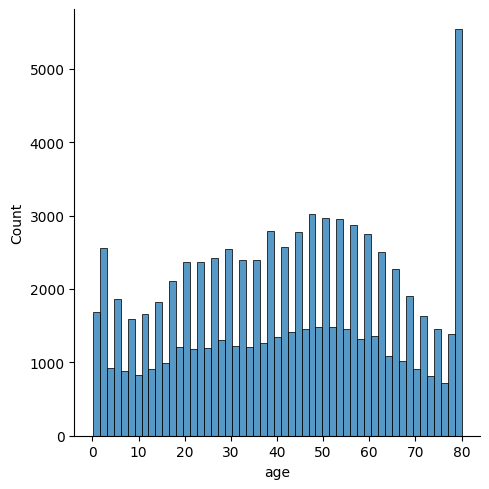

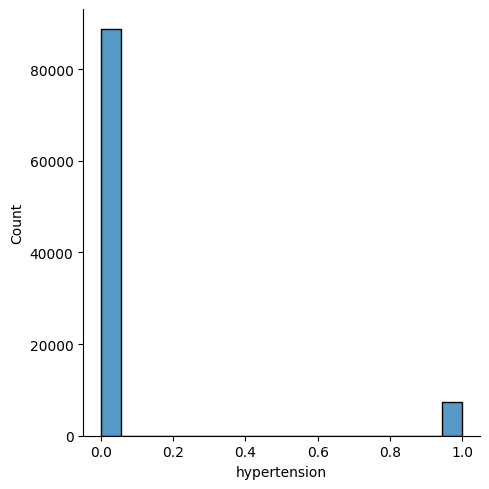

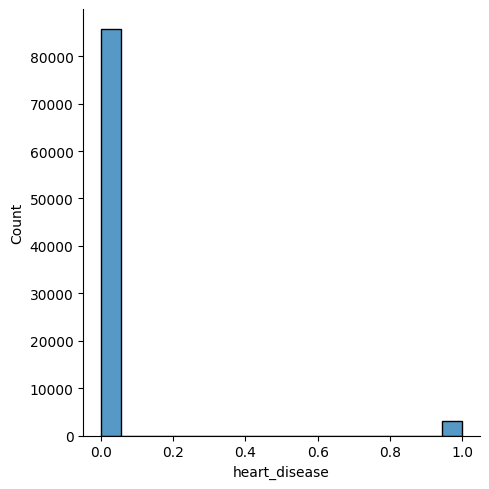

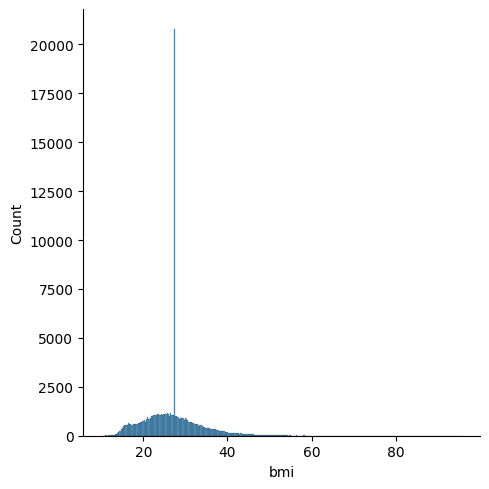

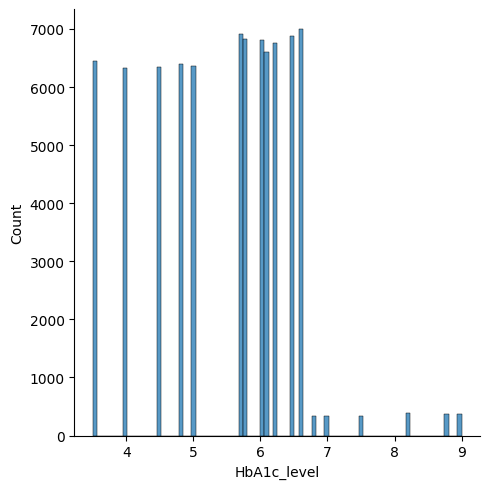

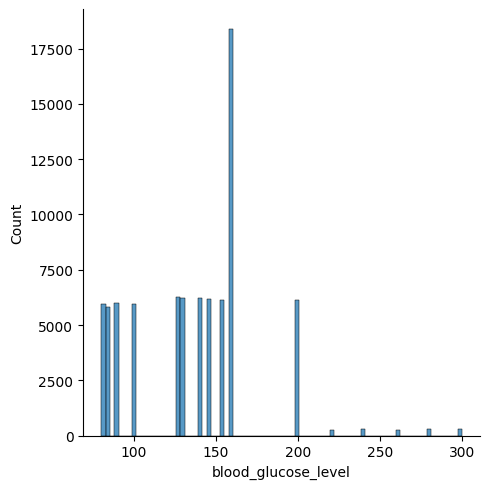

In [ ]:
for i in col_num:
  ans=outlierRemoval_Std(df,i)
  df=ans[0]
  if(ans[1]):
    print("Outlier exists in :",i,end="\n")
  print()

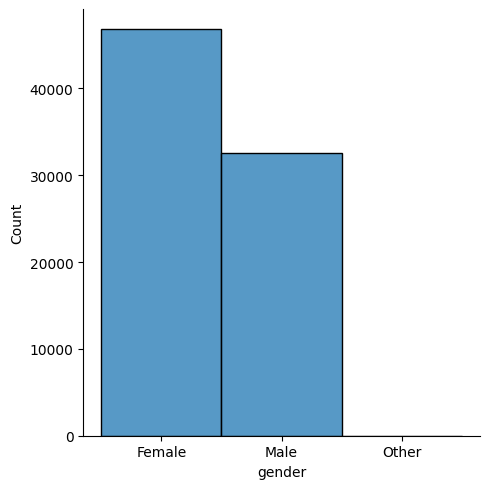

In [ ]:
#Gender
# temp=df['gender'].value_counts()
# temp=temp.sort_index()
# temp.plot(kind='bar')
sns.displot(df['gender'],kind='hist')

#### Method 2 - using IQR method

In [ ]:
def outlierRemoval_iqr(df,feature):
  #plotting
  sns.displot(df[feature],kind='hist')

  q1=df[feature].quantile(.25)
  q3=df[feature].quantile(.75)
  iqr=q3-q1
  low= q1 - 1.5*iqr
  high= q3 + 1.5*iqr
  minn=df[feature].min()
  maxx=df[feature].max()
  print(feature,": ",low,high,minn,maxx)
  df=df[(df[feature]>=low) & (df[feature]<=high)]

  if(minn<low or maxx>high):
     return [df,True]
  else:
     return [df,False]

age :  -28.5 111.5 0.08 80.0

bmi :  13.709999999999997 39.55 10.01 95.69
Outlier exists in : bmi

HbA1c_level :  2.6999999999999993 8.3 3.5 9.0
Outlier exists in : HbA1c_level

blood_glucose_level :  11.5 247.5 80 300
Outlier exists in : blood_glucose_level



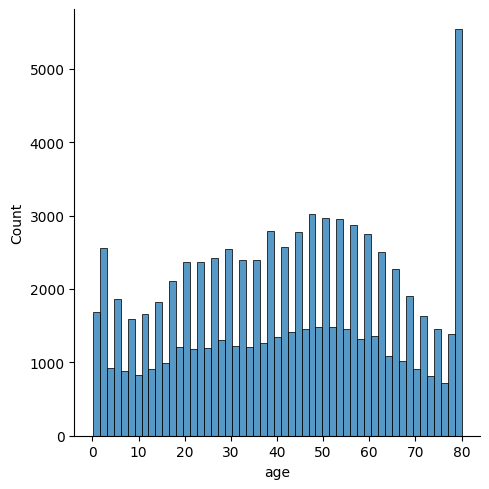

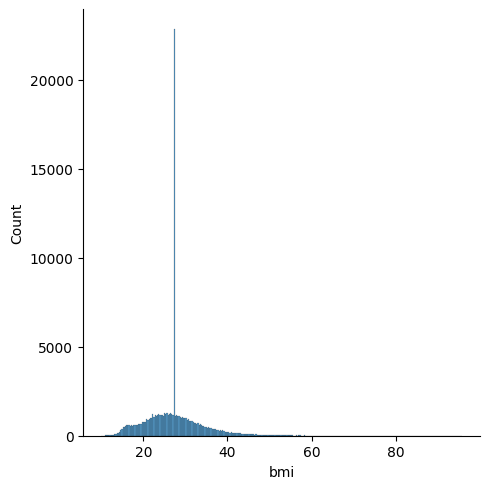

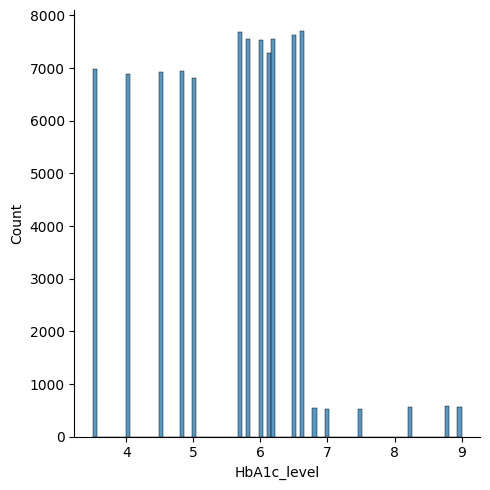

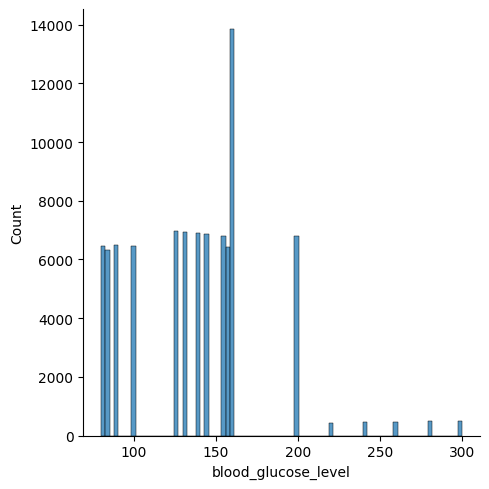

In [ ]:
for i in col_num:
  if(i not in ['hypertension','heart_disease']):
    ans=outlierRemoval_iqr(df,i)
    df=ans[0]
    if(ans[1]):
      print("Outlier exists in :",i,end="\n")
    print()

In [ ]:
df['age'].count()

88195

### Additional Part ends ###

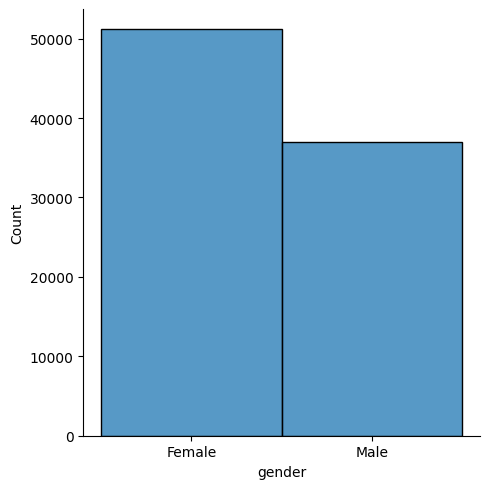

In [ ]:
#removing age outlier
df=df[df['gender']!='Other']
sns.displot(df['gender'],kind='hist')

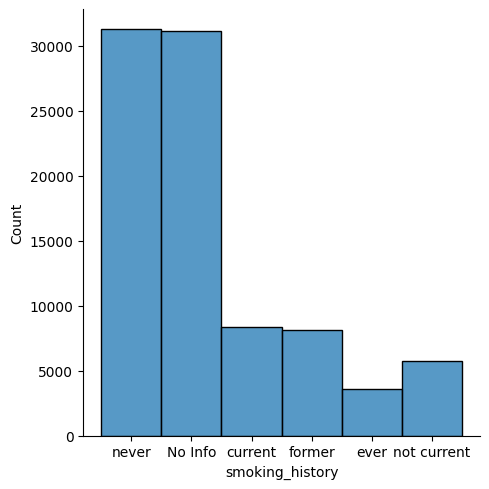

In [ ]:
#smoking history
sns.displot(df['smoking_history'],kind='hist')

In [ ]:
df.to_csv('Dataset_cleaned.csv',index=False)

Cleaning done & cleaned dataset stored in 'Dataset_cleaned.csv' file --------------

## Dataset normalization & other feature transformations

In [2]:
df=pd.read_csv("Dataset_cleaned.csv")

In [ ]:
#checking for datatype inconsistencies
for j in df:
  gtype=type(df[j][0])
  print("first",gtype)
  for i in range(len(list(df[j]))):
    if(type(df[j][i])!=gtype):
      print(j,i)

first <class 'str'>
first <class 'numpy.float64'>
first <class 'numpy.int64'>
first <class 'numpy.int64'>
first <class 'str'>
first <class 'numpy.float64'>
first <class 'numpy.float64'>
first <class 'numpy.int64'>
first <class 'numpy.int64'>


In [ ]:
#checking for datatype inconsistencies
gtype=type(df['age'][0])
for i in range(len(list(df['age']))):
  if(type(df['age'][i])!=gtype):
    print(i)

In [ ]:
df.shape

(88177, 9)

In [3]:
#storing unique values of each feature or column in a dictionary called 'col_uniques'
#this will be later used for mapping of raw to our need specific categories
col_uniques={}
for i in df.columns:
  col_uniques[i]=list(df[str(i)].unique())

In [ ]:
#testing
for i in col_uniques:
  print(type(col_uniques[i][0]))

<class 'str'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'str'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [ ]:
#testing
df.groupby('age').count()

,gender,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
age,,,,,,,,
0.08,17,17,17,17,17,17,17,17
0.16,34,34,34,34,34,34,34,34
0.24,70,70,70,70,70,70,70,70
0.32,81,81,81,81,81,81,81,81
0.40,58,58,58,58,58,58,58,58
...,...,...,...,...,...,...,...,...
76.00,660,660,660,660,660,660,660,660
77.00,658,658,658,658,658,658,658,658
78.00,605,605,605,605,605,605,605,605


In [ ]:
#data exploration
for i in col_uniques:
  print(i,":",len(col_uniques[i]),type(col_uniques[i][0]))

gender : 2 <class 'str'>
age : 102 <class 'numpy.float64'>
hypertension : 2 <class 'numpy.int64'>
heart_disease : 2 <class 'numpy.int64'>
smoking_history : 6 <class 'str'>
bmi : 2582 <class 'numpy.float64'>
HbA1c_level : 16 <class 'numpy.float64'>
blood_glucose_level : 15 <class 'numpy.int64'>
diabetes : 2 <class 'numpy.int64'>


In [4]:
#now creating a map from real data values to class value for each feature which is not already categorical
#this applies to the features- gender, age, smoking_history, bmi, HbA1c_level, blood_glucose_level
#so we will create 6 maps
ct1=0
genderMap={}
for i in col_uniques['gender']:
  genderMap[i]=ct1
  ct1+=1

ct1=0
smoking_historyMap={}
for i in col_uniques['smoking_history']:
  smoking_historyMap[i]=ct1
  ct1+=1

ct1=0
ageMap={}
for i in col_uniques['age']:
  ageMap[i]=int(i//10)

In [ ]:
#testing
col_uniques['age']

[80.0,
 54.0,
 28.0,
 36.0,
 76.0,
 20.0,
 44.0,
 79.0,
 42.0,
 32.0,
 53.0,
 78.0,
 67.0,
 15.0,
 37.0,
 40.0,
 5.0,
 69.0,
 72.0,
 4.0,
 30.0,
 45.0,
 43.0,
 50.0,
 41.0,
 26.0,
 77.0,
 66.0,
 29.0,
 60.0,
 38.0,
 3.0,
 57.0,
 74.0,
 19.0,
 46.0,
 21.0,
 59.0,
 27.0,
 13.0,
 56.0,
 2.0,
 7.0,
 11.0,
 34.0,
 6.0,
 55.0,
 9.0,
 62.0,
 47.0,
 12.0,
 68.0,
 75.0,
 22.0,
 58.0,
 18.0,
 24.0,
 17.0,
 25.0,
 0.08,
 16.0,
 33.0,
 31.0,
 8.0,
 49.0,
 39.0,
 65.0,
 14.0,
 70.0,
 0.56,
 48.0,
 51.0,
 71.0,
 0.88,
 64.0,
 63.0,
 52.0,
 10.0,
 35.0,
 61.0,
 73.0,
 0.16,
 23.0,
 0.64,
 1.16,
 1.64,
 0.72,
 1.88,
 1.32,
 0.8,
 1.24,
 1.0,
 1.8,
 0.48,
 1.56,
 1.08,
 0.24,
 1.4,
 0.32,
 0.4,
 1.72,
 1.48]

In [ ]:
#testing
# genderMap
# smoking_historyMap
ageMap

{80.0: 8,
 54.0: 5,
 28.0: 2,
 36.0: 3,
 76.0: 7,
 20.0: 2,
 44.0: 4,
 79.0: 7,
 42.0: 4,
 32.0: 3,
 53.0: 5,
 78.0: 7,
 67.0: 6,
 15.0: 1,
 37.0: 3,
 40.0: 4,
 5.0: 0,
 69.0: 6,
 72.0: 7,
 4.0: 0,
 30.0: 3,
 45.0: 4,
 43.0: 4,
 50.0: 5,
 41.0: 4,
 26.0: 2,
 77.0: 7,
 66.0: 6,
 29.0: 2,
 60.0: 6,
 38.0: 3,
 3.0: 0,
 57.0: 5,
 74.0: 7,
 19.0: 1,
 46.0: 4,
 21.0: 2,
 59.0: 5,
 27.0: 2,
 13.0: 1,
 56.0: 5,
 2.0: 0,
 7.0: 0,
 11.0: 1,
 34.0: 3,
 6.0: 0,
 55.0: 5,
 9.0: 0,
 62.0: 6,
 47.0: 4,
 12.0: 1,
 68.0: 6,
 75.0: 7,
 22.0: 2,
 58.0: 5,
 18.0: 1,
 24.0: 2,
 17.0: 1,
 25.0: 2,
 0.08: 0,
 16.0: 1,
 33.0: 3,
 31.0: 3,
 8.0: 0,
 49.0: 4,
 39.0: 3,
 65.0: 6,
 14.0: 1,
 70.0: 7,
 0.56: 0,
 48.0: 4,
 51.0: 5,
 71.0: 7,
 0.88: 0,
 64.0: 6,
 63.0: 6,
 52.0: 5,
 10.0: 1,
 35.0: 3,
 61.0: 6,
 73.0: 7,
 0.16: 0,
 23.0: 2,
 0.64: 0,
 1.16: 0,
 1.64: 0,
 0.72: 0,
 1.88: 0,
 1.32: 0,
 0.8: 0,
 1.24: 0,
 1.0: 0,
 1.8: 0,
 0.48: 0,
 1.56: 0,
 1.08: 0,
 0.24: 0,
 1.4: 0,
 0.32: 0,
 0.4: 0,
 1.72: 0,
 1.

In [ ]:
#Data exploration
df.groupby('HbA1c_level').count()

,gender,age,hypertension,heart_disease,smoking_history,bmi,blood_glucose_level,diabetes
HbA1c_level,,,,,,,,
3.5,6972,6972,6972,6972,6972,6972,6972,6972
4.0,6877,6877,6877,6877,6877,6877,6877,6877
4.5,6928,6928,6928,6928,6928,6928,6928,6928
4.8,6952,6952,6952,6952,6952,6952,6952,6952
5.0,6816,6816,6816,6816,6816,6816,6816,6816
5.7,7531,7531,7531,7531,7531,7531,7531,7531
5.8,7418,7418,7418,7418,7418,7418,7418,7418
6.0,7407,7407,7407,7407,7407,7407,7407,7407
6.1,7144,7144,7144,7144,7144,7144,7144,7144


In [5]:
#creating equal frequency categories for HbA1c_level feature by automating the process

temp=df['HbA1c_level'].value_counts()
temp=temp.sort_index()
HbA1c_level_ind=list(temp.index)

<Axes: >

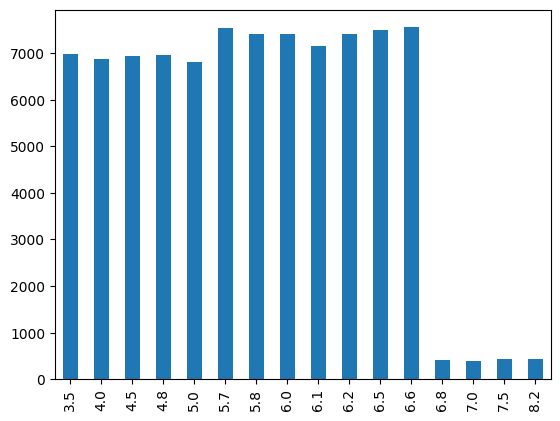

In [ ]:
#Data exploration
temp.plot(kind='bar')

In [ ]:
#testing
df.shape

(88177, 9)

In [ ]:
#Data exploration
df['blood_glucose_level'].value_counts().sort_index()

80     6468
85     6324
90     6495
100    6462
126    6961
130    6940
140    6898
145    6861
155    6793
158    6423
159    6956
160    6877
200    6810
220     431
240     478
Name: blood_glucose_level, dtype: int64

In [6]:
#this is the script which automates the process of defining class ranges for feature based on the frequency distribution and no of classes required
#here no of classes required is given by us, which is in the variable 'k'
k=5;
breakpt=(df.shape[0])/k
print(breakpt)

ct=0
s=0
HbA1c_levelMap={}
itr=0
for i in temp:
  s+=i;
  if s>=breakpt:
    s=0
    ct+=1
  HbA1c_levelMap[HbA1c_level_ind[itr]]=ct
  itr+=1

#bmi map based on scientifically calculated categories (pre-defined)
bmiMap={}
for i in col_uniques['bmi']:
  if(i>=30):
    bmiMap[i]=3
  elif(i>=25):
    bmiMap[i]=2
  elif(i>=18.5):
    bmiMap[i]=1
  else:
    bmiMap[i]=0


temp1=df['blood_glucose_level'].value_counts().sort_index()
blood_glucose_level_ind=list(temp1.index)
blood_glucose_levelMap={}
ct=0
s=0
itr=0
for i in temp1:
  s+=i;
  if s>=breakpt:
    s=0
    ct+=1
  blood_glucose_levelMap[blood_glucose_level_ind[itr]]=ct
  itr+=1


17635.4


In [ ]:
#testing
temp1.index

Int64Index([80, 85, 90, 100, 126, 130, 140, 145, 155, 158, 159, 160, 200, 220,
            240],
           dtype='int64')

In [ ]:
#testing

# HbA1c_levelMap
# bmiMap
blood_glucose_levelMap

{80: 0,
 85: 0,
 90: 1,
 100: 1,
 126: 1,
 130: 2,
 140: 2,
 145: 2,
 155: 3,
 158: 3,
 159: 3,
 160: 4,
 200: 4,
 220: 4,
 240: 4}

In [ ]:
#Data exploration
for i in col_uniques:
  print(i,":",len(col_uniques[i]),type(col_uniques[i][0]))

gender : 2 <class 'str'>
age : 102 <class 'numpy.float64'>
hypertension : 2 <class 'numpy.int64'>
heart_disease : 2 <class 'numpy.int64'>
smoking_history : 6 <class 'str'>
bmi : 2582 <class 'numpy.float64'>
HbA1c_level : 16 <class 'numpy.float64'>
blood_glucose_level : 15 <class 'numpy.int64'>
diabetes : 2 <class 'numpy.int64'>


In [7]:
#this is master map used for storing all other maps and will further help to automate the entire process of substitution of values in the csv file


masterMap={'gender':genderMap,'age':ageMap,'smoking_history':smoking_historyMap,'bmi':bmiMap,'HbA1c_level':HbA1c_levelMap,'blood_glucose_level':blood_glucose_levelMap}

In [ ]:
#Data exploration
for i in masterMap:
  print(i,len(masterMap[i]),type(masterMap[i]))

gender 2 <class 'dict'>
age 102 <class 'dict'>
smoking_history 6 <class 'dict'>
bmi 2582 <class 'dict'>
HbA1c_level 16 <class 'dict'>
blood_glucose_level 15 <class 'dict'>


In [ ]:
#testing
type(masterMap['gender']['Female'])

int

In [ ]:
#final substitution step using masterMap

for i in df:
  if(i not in ['hypertension','heart_disease','diabetes']):
    print(i)
    for j in range(0,len(df[i])):
      # print(type(i),type(df[i][j]))
      # print(i,df[i][j])
      df[i][j]=np.int64(masterMap[i][df[i][j]])

gender


<ipython-input-65-1b193bddeaac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][j]=np.int64(masterMap[i][df[i][j]])


age
smoking_history
bmi
HbA1c_level
blood_glucose_level


In [ ]:
#testing
''' type(df['age'])
type(df['age'][0])
type(genderMap['Female'])
df['gender']
df.head(10000)
for i in df:
  for j in range(len(df[i])):
    print(df[i][j]) '''

In [ ]:
#testing
len(list(df['gender']))

88177

In [ ]:
#Data exploration
df.head(100)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,8.0,0,1,0,2.0,4.0,2,0
1,0,5.0,0,0,1,2.0,4.0,0,0
2,1,2.0,0,0,0,2.0,2.0,3,0
3,0,3.0,0,0,2,1.0,1.0,3,0
4,1,7.0,1,1,2,1.0,1.0,3,0
...,...,...,...,...,...,...,...,...,...
95,0,5.0,0,0,0,1.0,2.0,2,0
96,0,8.0,0,0,1,2.0,1.0,0,0
97,0,8.0,0,0,0,3.0,0.0,2,0
98,1,4.0,0,0,1,2.0,1.0,4,0


In [ ]:
df.to_csv('Dataset_final.csv',index=False)

In [8]:
ff=open('Normalization_file.bin','wb')
pickle.dump(masterMap,ff)
ff.close()

Dataset preprocessing Ends & final dataset stored in 'Dataset_final.csv' ------------------------

## Data Correlation

In [ ]:
df=pd.read_csv("Diabetes-dataset-before-cleaning.csv")

In [ ]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

non-smoker     70911
past_smoker    19803
current         9286
Name: smoking_history, dtype: int64


In [ ]:
data = df.copy()

In [ ]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

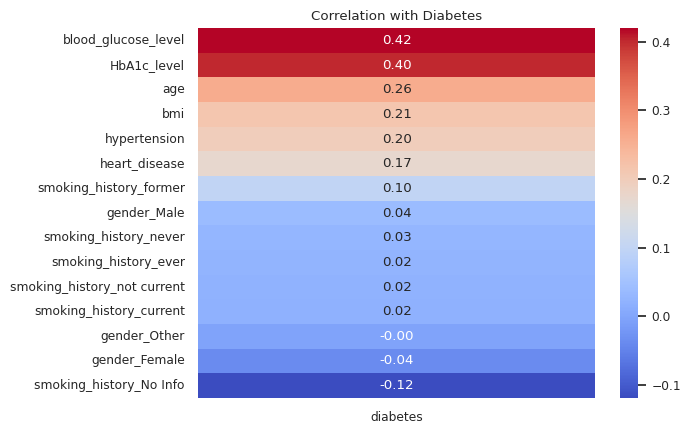

In [ ]:
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

# Classification

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb

from imblearn import*

In [ ]:
df=pd.read_csv('Dataset_final.csv');

In [ ]:
df.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,88177.000000,88177.000000,88177.000000,88177.000000,88177.000000,88177.000000,88177.000000,88177.000000,88177.000000
mean,0.419588,3.682139,0.068465,0.036880,1.307983,1.767343,1.910419,2.043798,0.052372
std,0.493494,2.293986,0.252543,0.188469,1.460758,0.870558,1.234215,1.301985,0.222777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,0.000000,4.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,0.000000
75%,1.000000,5.000000,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,0.000000
max,1.000000,8.000000,1.000000,1.000000,5.000000,3.000000,4.000000,4.000000,1.000000


In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,8.0,0,1,0,2.0,4.0,2,0
1,0,5.0,0,0,1,2.0,4.0,0,0
2,1,2.0,0,0,0,2.0,2.0,3,0
3,0,3.0,0,0,2,1.0,1.0,3,0
4,1,7.0,1,1,2,1.0,1.0,3,0


In [ ]:
df.groupby('diabetes').count()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
diabetes,,,,,,,,
0,83559,83559,83559,83559,83559,83559,83559,83559
1,4618,4618,4618,4618,4618,4618,4618,4618


In [ ]:
list(df['diabetes'].value_counts())

[83559, 4618]

In [ ]:
X = df.iloc[:,:-1]
X
print(type(X),len(X))

<class 'pandas.core.frame.DataFrame'> 88177


In [ ]:
Y=df.iloc[:,-1:]
Y

,diabetes
0,0
1,0
2,0
3,0
4,0
...,...
88172,0
88173,0
88174,0
88175,0


## Class imbalance handling

### Misc method

In [ ]:
nMax=10000
msk = df.groupby('diabetes')['diabetes'].transform('size') >= nMax
df = pd.concat((df[msk].groupby('diabetes').sample(n=nMax), df[~msk]), ignore_index=True)

In [ ]:
df.groupby('diabetes').count()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
diabetes,,,,,,,,
0,10000,10000,10000,10000,10000,10000,10000,10000
1,4618,4618,4618,4618,4618,4618,4618,4618


### Over Sampling method

**KMeans SMOTE**

In [ ]:
B_method = over_sampling.KMeansSMOTE(cluster_balance_threshold=0.1)
X_resampled , Y_resampled = B_method.fit_resample(X,Y)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print(type(X_resampled),len(X_resampled))
print(Y_resampled['diabetes'].value_counts())

<class 'pandas.core.frame.DataFrame'> 167120
1    83561
0    83559
Name: diabetes, dtype: int64


### Under Sampling method

**Edited Nearest Neighbours (Prototype Selection)**

In [ ]:
B_method = under_sampling.EditedNearestNeighbours()
X_resampled , Y_resampled = B_method.fit_resample(X,Y)

In [ ]:
print(Y_resampled['diabetes'].value_counts())

0    76859
1     4618
Name: diabetes, dtype: int64


**Neighbourhood Cleaning Rule (Prototype Selection) (iii)**

In [ ]:
for i in range(50):
    B_method = under_sampling.NeighbourhoodCleaningRule()
    X_resampled , Y_resampled = B_method.fit_resample(X,Y)
    X = X_resampled;Y = Y_resampled

In [ ]:
print(Y_resampled['diabetes'].value_counts())

0    44012
1     4618
Name: diabetes, dtype: int64


### Under-Over Sampling

**SMOTE-Tomek**

In [ ]:
B_method = combine.SMOTETomek(random_state=42,n_jobs=-1)
X_resampled , Y_resampled = B_method.fit_resample(X,Y)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [ ]:
print(Y_resampled['diabetes'].value_counts())

0    83559
1    83559
Name: diabetes, dtype: int64


**SMOTE-ENN**

In [ ]:
B_method = combine.SMOTEENN(random_state=42,n_jobs=-1)
X_resampled , Y_resampled = B_method.fit_resample(X,Y)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [ ]:
print(Y_resampled['diabetes'].value_counts())

0    76148
1    47994
Name: diabetes, dtype: int64


## Main classification task

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, random_state = 42)

In [ ]:
classifier1 = LogisticRegression(solver = "lbfgs")
classifier2 = DecisionTreeClassifier()
classifier3 = SVC()
classifier4 = GaussianNB()
classifier5 = MLPClassifier()
classifier6 = RandomForestClassifier()
# classifier7 = xgb.XGBClassifier()
# classifier8 = AdaBoostClassifier()
clf= [classifier1,classifier2,classifier3,classifier4,classifier5,classifier6]

In [ ]:
clfarr=[]
maxx=-1
for i in clf:
  i.fit(X_train, Y_train)
  f=i.score(X_test, Y_test)
  clfarr.append(i)
  if f>maxx:
    maxx=f
    classifier=i

print(maxx,classifier)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

0.9949004770521467 RandomForestClassifier()


In [ ]:
for i in range(6):
  Y_pred=clfarr[i].predict(X_test)
  test_report=classification_report(Y_test,Y_pred)
  print(clfarr[i])
  print(test_report)
  print()

LogisticRegression()
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11008
           1       0.88      0.79      0.83      1150

    accuracy                           0.97     12158
   macro avg       0.93      0.89      0.91     12158
weighted avg       0.97      0.97      0.97     12158


DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11008
           1       0.99      0.96      0.97      1150

    accuracy                           0.99     12158
   macro avg       0.99      0.98      0.98     12158
weighted avg       0.99      0.99      0.99     12158


SVC()
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11008
           1       0.92      0.92      0.92      1150

    accuracy                           0.98     12158
   macro avg       0.95      0.96      0.95     12158
weighted avg       0

In [ ]:
print(classifier," = ",classifier.score(X_test,Y_test))

RandomForestClassifier()  =  0.9949004770521467


In [ ]:
Y_pred=classifier.predict(X_test)

In [ ]:
test_report=classification_report(Y_test,Y_pred)

In [ ]:
print(test_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11008
           1       0.99      0.96      0.97      1150

    accuracy                           0.99     12158
   macro avg       0.99      0.98      0.98     12158
weighted avg       0.99      0.99      0.99     12158



In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
cm

array([[10997,    11],
       [   51,  1099]])

In [ ]:
#Storing trained model in pickle file (binary file)
#currently using:
#outlier method 2
#undersampling - Neighbourhood Cleaning Rule (Prototype Selection) (iii)
ff=open("Final_Model.bin",'wb')
pickle.dump(classifier,ff)
ff.close()

# User Input

In [4]:
ff=open("Final_Model.bin",'rb')
classifier=pickle.load(ff)
ff.close()
ff=open('Normalization_file.bin','rb')
masterMap=pickle.load(ff)
ff.close()
blood_glucose_levelMap,HbA1c_levelMap,bmiMap = masterMap['blood_glucose_level'],masterMap['HbA1c_level'],masterMap['bmi']

In [5]:

print("First 4 are compulsary features.\nIf any other feature's value is not known then enter `-1` \n")

hypertension= 0  #Median value
heart_disease= 0 #Median value
smoking_history= 1 #Max relevance value

blood_glucose_level=int(input("Enter blood glucose level (in mg/dL):"))
HbA1c_level=float(input("Enter HbA1c_level(in %):"))
age=int(input("Enter age:"))
bmi=float(input("Enter bmi:"))
gender=int(input("Enter from {'Female': 0, 'Male': 1} : "))

choice=input("Is hypertension known(Y/N) ?")
if(choice=='Y'):
  hypertension=int(input("Do you have hypertension(1/0) ?"))

choice=input("Is heart_disease known(Y/N) ?")
if(choice=='Y'):
  heart_disease=int(input("Do you have heart_disease(1/0) ?"))

choice=input("Is smoking_history known(Y/N) ?")
if(choice=='Y'):
  smoking_history=int(input("Smoking history:\nEnter from { 'never': 0,'No Info': 1,'current': 2,'former': 3,'ever': 4,'not current': 5} :"))

ind=bisect.bisect_left(list(blood_glucose_levelMap.keys()),blood_glucose_level,0,len(blood_glucose_levelMap))
if(ind>= len(blood_glucose_levelMap)):
  blood_glucose_level= 4 + (blood_glucose_level-240)//30
else:
  blood_glucose_level=blood_glucose_levelMap[list(blood_glucose_levelMap.keys())[ind]]

ind=bisect.bisect_left(list(HbA1c_levelMap.keys()),HbA1c_level,0,len(HbA1c_levelMap))
if(ind>= len(HbA1c_levelMap)):
  HbA1c_level=4 + (HbA1c_level-8.2)//2
else:
  HbA1c_level=HbA1c_levelMap[list(HbA1c_levelMap.keys())[ind]]

age=age//10

ind=bisect.bisect_left(list(bmiMap.keys()),bmi,0,len(bmiMap))
if(ind>= len(bmiMap)):
  ind-=1
bmi=bmiMap[list(bmiMap.keys())[ind]]

First 4 are compulsary features.
If any other feature's value is not known then enter `-1` 

Enter blood glucose level (in mg/dL):100
Enter HbA1c_level(in %):5.12
Enter age:20
Enter bmi:19
Enter from {'Female': 0, 'Male': 1} : 1
Is hypertension known(Y/N) ?N
Is heart_disease known(Y/N) ?N
Is smoking_history known(Y/N) ?Y
Smoking history:
Enter from { 'never': 0,'No Info': 1,'current': 2,'former': 3,'ever': 4,'not current': 5} :0


In [ ]:
#testing
blood_glucose_levelMap
blood_glucose_level=210
ind=bisect.bisect_left(list(blood_glucose_levelMap.keys()),blood_glucose_level,0,len(blood_glucose_levelMap))
ind
val=blood_glucose_levelMap[list(blood_glucose_levelMap.keys())[ind]]
val

In [6]:
df_user=pd.DataFrame({'gender':[gender], 'age':[age], 'hypertension':[hypertension], 'heart_disease':[heart_disease], 'smoking_history':[smoking_history],'bmi':[bmi], 'HbA1c_level':[HbA1c_level], 'blood_glucose_level':[blood_glucose_level]})

In [7]:
df_user

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1,2,0,0,0,1,2,1


In [8]:
diabetes_predict_user=classifier.predict(df_user)

In [9]:
ans=list(diabetes_predict_user)[0]
if ans:
  print("You have diabetes.")
else:
  print("Congrats you are diabetes free!")

Congrats you are diabetes free!


# Results

## Outlier Method 1

**Outlier method1, old normalization, no undersampling**  
accuracy =97, recall (of diabetes=1) = 2

**Outlier method1, old normalization, old  undersampling=5000 max size**  
accuracy =84, recall (of diabetes=1) = 78

**Conclusion**: outlier method 1 is v bad as it is meant for only normally distributed data, and not for data of skewed nature like this one. It removes all hypertension parameters with val=1 (for an ex).

## Outlier Method 2

**Outlier Method 2, old normalization, no undersampling**  
accuracy= 95, recall(of diabetes=1)= 29

**Outlier Method 2, old normalization, undersampling=10000 max**  
accuracy= 86, recall(of diabetes=1) = 79

**oversampling - KMeans SMOTE**  
model= RandomForest  
accuracy= 95, recall (of diabetes=1) = 96

**undersampling - Edited Nearest Neighbours (Prototype Selection)**  
model= RandomForest  
accuracy= 97, recall (of diabetes=1) = 61

**undersampling - Neighbourhood Cleaning Rule (Prototype Selection) (iii)**  
model= RandomForest  
accuracy= 100, recall (of diabetes=1) = 99

**under-over sampling - SMOTE-Tomek**  
model= DecisionTreeClassifier  
accuracy= 92, recall (of diabetes=1) = 95

**under-over sampling - SMOTE-Tomek**  
model= RandomForest  
accuracy= 96, recall (of diabetes=1) = 94